In [1]:
#Importing Libararies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import folium
pd.set_option('display.precision',5)

In [2]:
# Loading Dataset
start_time = time.time()
users=pd.read_csv("./Dataset/users.csv")
products=pd.read_csv("./Dataset/products.csv")
inventory_items=pd.read_csv("./Dataset/inventory_items.csv")
orders=pd.read_csv("./Dataset/orders.csv")
order_items=pd.read_csv("./Dataset/order_items.csv")
events=pd.read_csv("./Dataset/events.csv")
dist_centers=pd.read_csv("./Dataset/distribution_centers.csv")
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

9.578984022140503


In [3]:
def get_unique_values_by_each_column(data):
    for df in data:
        for column in df.columns:
            unique_values = df[column].nunique()
            print(f"{column}: {unique_values}")

def drop_null_values(data, columns=[]):
    return data.dropna(subset=columns)

In [4]:
get_unique_values_by_each_column([orders])

order_id: 125226
user_id: 80044
status: 5
gender: 2
created_at: 117373
returned_at: 12478
shipped_at: 79123
delivered_at: 43187
num_of_item: 4


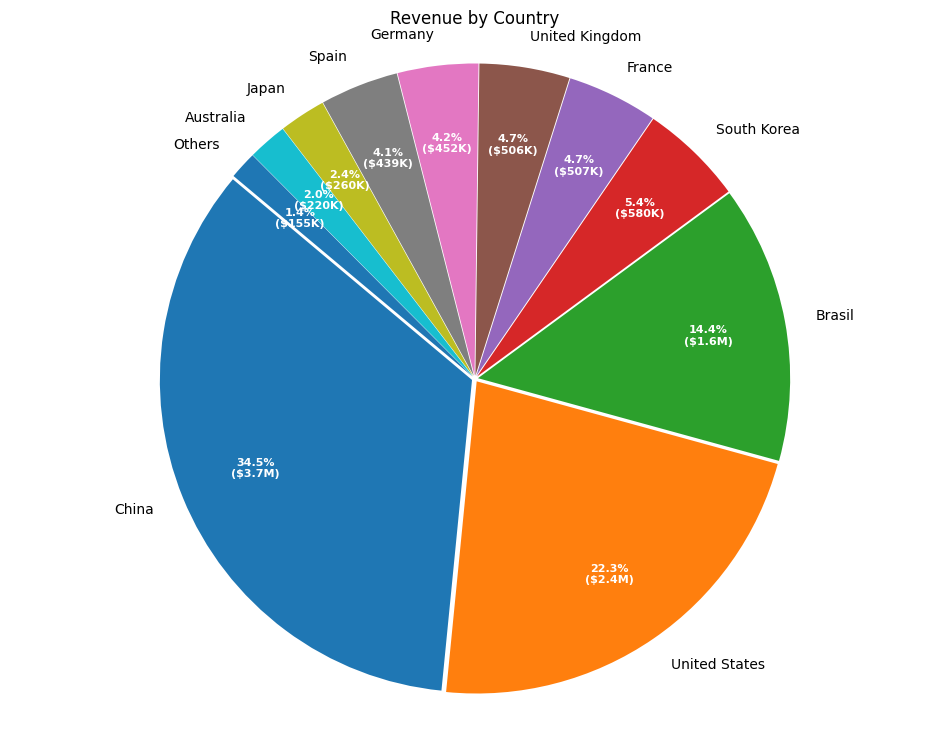

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming order_items, products, orders, and users DataFrames are already defined

# Merge order_items with products to get product prices
order_items_products_df = pd.merge(order_items, products, left_on='product_id', right_on='id')

# Merge with orders to associate each order item with a user
order_items_orders = pd.merge(order_items_products_df, orders, left_on='order_id', right_on='order_id')

# Merge the resulting DataFrame with users_df to get the state for each order
final_df = pd.merge(order_items_orders, users, left_on='user_id_x', right_on='id')

# Group by country and sum retail prices
revenue_by_state = final_df.groupby('country')['retail_price'].sum().sort_values(ascending=False)

# Select top 10 and sum others
top_10 = revenue_by_state.head(10)
others = revenue_by_state[10:].sum()
final_revenue = pd.concat([top_10, pd.Series({'Others': others})])

import matplotlib.pyplot as plt

# Assuming 'final_revenue' is already defined with your revenue data

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # Using 'K' (thousands) or 'M' (millions) for better readability
        if val >= 1000000:
            val_str = '${:,.1f}M'.format(val/1000000)
        elif val >= 1000:
            val_str = '${:,.0f}K'.format(val/1000)
        else:
            val_str = '${:,}'.format(val)
        return '{p:.1f}%\n({v})'.format(p=pct, v=val_str)
    return my_format

# Set explode to slightly separate each slice
explode = [0.01] * len(final_revenue)

plt.figure(figsize=(12, 9))
wedges, texts, autotexts = plt.pie(final_revenue.values, labels=final_revenue.index, explode=explode,
                                   autopct=autopct_format(final_revenue.values), pctdistance=0.75, startangle=140)

# Customize texts and autotexts (percentage labels)
plt.setp(texts, size=10)  # Set the properties on the country labels
plt.setp(autotexts, size=8, color="white", weight="bold")  # Set the properties on the autotexts for percentages

plt.title('Revenue by Country')
plt.axis('equal')  # Ensures that pie is drawn as a circle

plt.show()



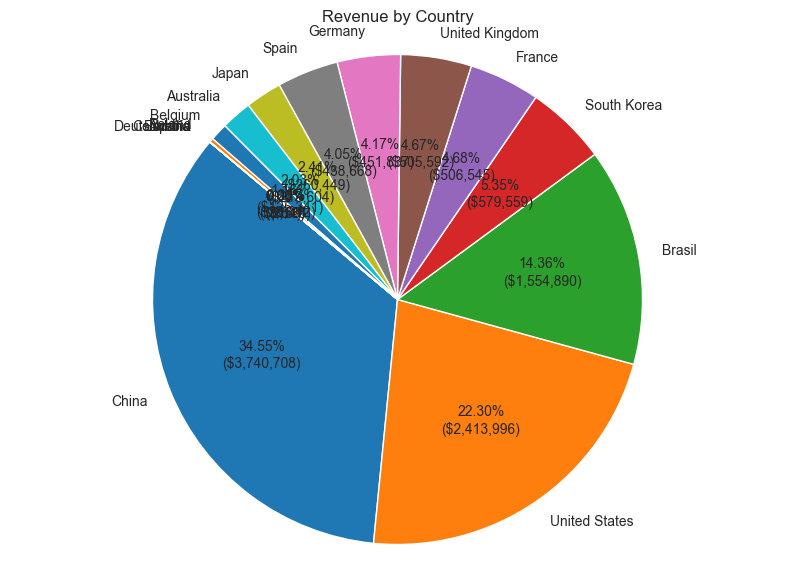

In [32]:
# Merge order_items_df with products_df to get product prices
order_items_products_df = pd.merge(order_items, products, left_on='product_id', right_on='id')
# Merge with orders to associate each order item with a user
order_items_orders = pd.merge(order_items_products_df, orders, left_on='order_id', right_on='order_id')

# Merge the resulting DataFrame with users_df to get the state for each order
final_df = pd.merge(order_items_orders, users, left_on='user_id_x', right_on='id')

revenue_by_state = final_df.groupby('country')['retail_price'].sum().sort_values(ascending=False)

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n(${v:,})'.format(p=pct, v=val)
    return my_format

plt.figure(figsize=(10, 7))
plt.pie(revenue_by_state.values, labels=revenue_by_state.index, 
        autopct=autopct_format(revenue_by_state.values), startangle=140)
plt.title('Revenue by Country')
plt.axis('equal')  # Ensures that pie is drawn as a circle.
#plt.savefig('Revenue_by_country.png')
plt.show()

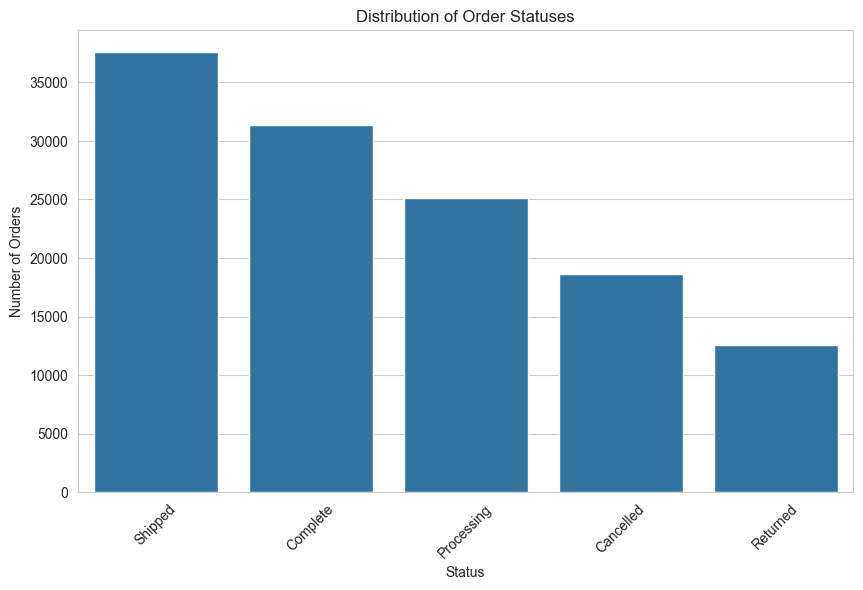

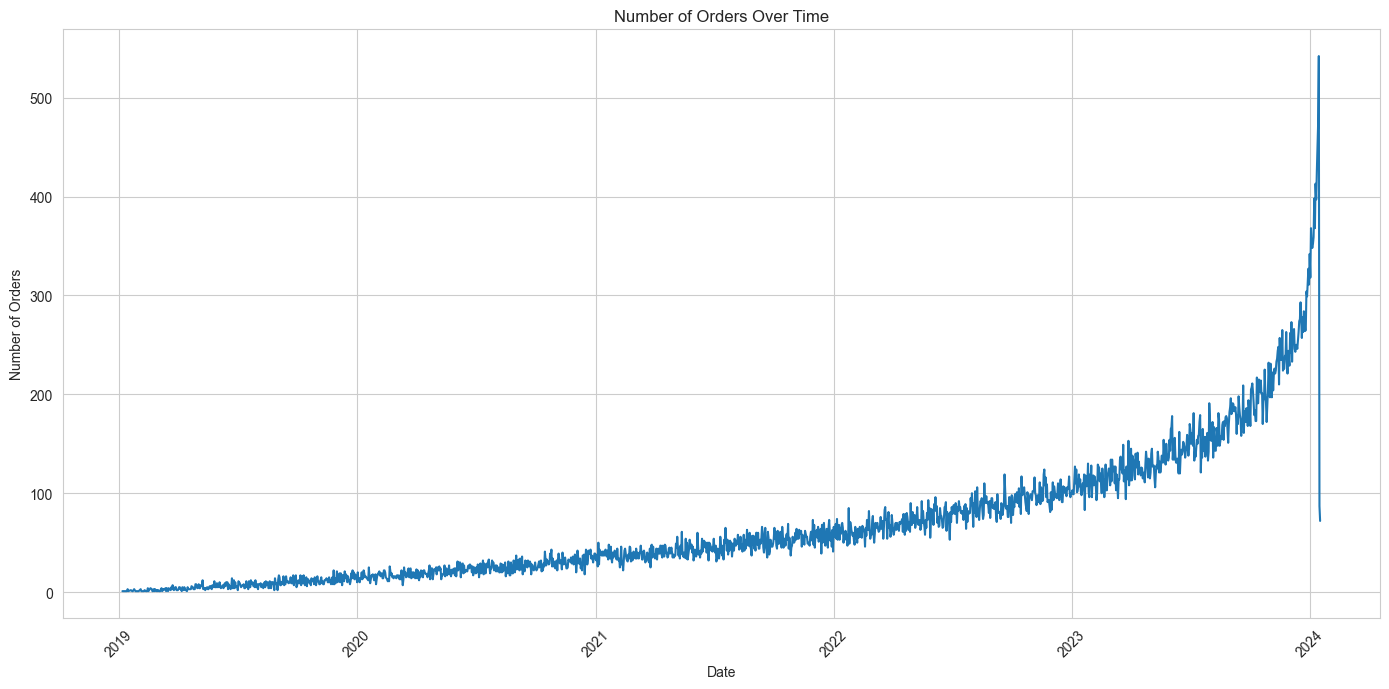

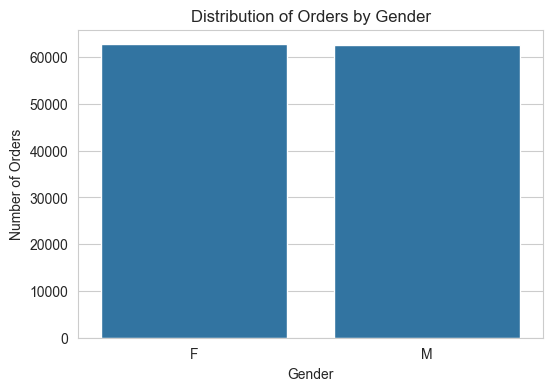

In [33]:
# Convert datetime columns with automatic parsing
orders['created_at'] = pd.to_datetime(orders['created_at'], errors='coerce', utc=True)
orders['returned_at'] = pd.to_datetime(orders['returned_at'], errors='coerce', utc=True)
orders['shipped_at'] = pd.to_datetime(orders['shipped_at'], errors='coerce', utc=True)
orders['delivered_at'] = pd.to_datetime(orders['delivered_at'], errors='coerce', utc=True)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot distribution of order statuses
plt.figure(figsize=(10, 6))
sns.countplot(data=orders, x='status', order = orders['status'].value_counts().index)
plt.title('Distribution of Order Statuses')
plt.xlabel('Status')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.savefig('Distribution_of_Order_Statuses.png')
plt.show()
# Plot distribution of orders over time (by month)
orders['created_at_date'] = orders['created_at'].dt.date  # Extract just the date part for simplicity
orders_over_time = orders.groupby('created_at_date').size()

plt.figure(figsize=(14, 7))
orders_over_time.plot(kind='line')
plt.title('Number of Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

# Plot distribution of orders by gender
plt.figure(figsize=(6, 4))
sns.countplot(data=orders, x='gender')
plt.title('Distribution of Orders by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Orders')
plt.show()


# 1. Geospatial Analysis

In [34]:
# Initialize a base map
map = folium.Map(location=[45, 0], zoom_start=2)

# Plot distribution centers
for idx, row in dist_centers.iterrows():
    folium.Marker([row['latitude'], row['longitude']], 
                  popup=row['name'], 
                  icon=folium.Icon(color='red', icon='info-sign')
                 ).add_to(map)

sampled_users_df = users.sample(n=10000)

# Plot users
for idx, row in sampled_users_df.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']], 
                        radius=3, 
                        color='blue', 
                        fill=True, 
                        fill_color='blue', 
                        fill_opacity=0.5
                       ).add_to(map)

# Save or display the map
#map.save('map.html')
map


# 2. User Behavior Analysis

In [35]:
# Convert timestamps to datetime
events['created_at'] = pd.to_datetime(events['created_at'], errors='coerce')

# Session patterns
sessions_duration = events.groupby('session_id')['created_at'].agg(['min', 'max'])
sessions_duration['duration'] = (sessions_duration['max'] - sessions_duration['min']).dt.total_seconds()

# Traffic source distribution
traffic_sources = events['traffic_source'].value_counts(normalize=True) * 100

print(traffic_sources)
display(sessions_duration)


traffic_source
Email       44.90151
Adwords     30.06394
Facebook    10.02622
YouTube      9.98938
Organic      5.01895
Name: proportion, dtype: float64


min  \
session_id                                                       
00000763-a855-4ad0-a95c-b160e749b272 2021-10-01 03:26:00+00:00   
0000364a-ce41-46f1-89d6-3f8704af77db 2022-08-22 10:46:40+00:00   
00004b15-f2d4-4687-b4c1-fc9ce336d39a 2022-06-11 01:28:00+00:00   
00004cf0-0d54-4347-8b0c-dccc700a2c96 2021-12-28 03:11:00+00:00   
00004e02-6372-47a6-aaf7-f231de654979 2023-12-15 10:28:16+00:00   
...                                                        ...   
ffff7645-26f7-410f-8498-0c601d74c67a 2019-11-05 15:00:00+00:00   
ffff8086-da2c-4045-94ba-453437cd3289 2020-03-20 06:06:00+00:00   
ffffa9aa-4345-4c2a-b389-8fd58844472e 2021-07-26 15:45:00+00:00   
ffffc3b7-9bc3-44d0-935e-cfaf11c91a0e 2019-07-10 07:02:00+00:00   
ffffc96a-b665-41a1-8a9a-1101c46e6620 2022-08-25 00:34:05+00:00   

                                                           max  duration  
session_id                                                                
00000763-a855-4ad0-a95c-b160e749b272 2021-10-01 03:52:00+00:00    1560.0  
0000364a-ce41-46f1-89d6-3f8704af77db 2022-08-22 10:52:42+00:00     362.0  
00004b15-f2d4-4687-b4c1-fc9ce336d39a 2022-06-11 01:54:00+00:00    1560.0  
00004cf0-0d54-4347-8b0c-dccc700a2c96 2021-12-28 03:32:00+00:00    1260.0  
00004e02-6372-47a6-aaf7-f231de654979 2023-12-15 10:34:45+00:00     389.0  
...                                                        ...       ...  
ffff7645-26f7-410f-8498-0c601d74c67a 2019-11-05 15:39:00+00:00    2340.0  
ffff8086-da2c-4045-94ba-453437cd3289 2020-03-20 06:06:00+00:00       0.0  
ffffa9aa-4345-4c2a-b389-8fd58844472e 2021-07-26 15:49:00+00:00     240.0  
ffffc3b7-9bc3-44d0-935e-cfaf11c91a0e 2019-07-10 07:21:00+00:00    1140.0  
ffffc96a-b665-41a1-8a9a-1101c46e6620 2022-08-27 00:47:16+00:00  173591.0  

[681759 rows x 3 columns]

# 3. Sales and Revenue Analysis

In [36]:
# Assuming order_items and inventory_items can be joined on a common key (e.g., product_id)
# This is a simplification; you'll need to adjust based on your actual data schema
merged_df = pd.merge(order_items, inventory_items, on='product_id')
merged_df['quantity']=1
# Calculate revenue and cost
merged_df['revenue'] = merged_df['quantity'] * merged_df['sale_price']  # Adjust column names as needed
merged_df['profit'] = merged_df['revenue'] - (merged_df['quantity'] * merged_df['cost'])

# Aggregate revenue and profit
total_revenue = merged_df['revenue'].sum()
total_profit = merged_df['profit'].sum()

print(f"Total Revenue: {total_revenue:.2f}, Total Profit: {total_profit:.2f}")

Total Revenue: 215035754.37, Total Profit: 111604113.02


# 4. Product Performance Analysis

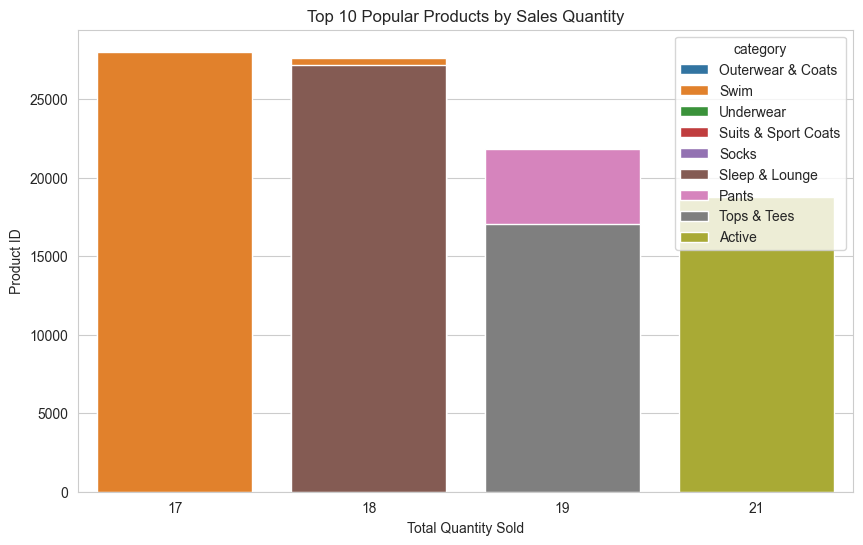

In [37]:
# Merge to get sales data for products
product_sales_df = pd.merge(order_items, products, left_on='product_id', right_on='id')
product_sales_df['quantity']=1
# Summarize sales by product
product_sales_summary = product_sales_df.groupby(['product_id', 'category'])['quantity'].sum().reset_index()

# Top 10 popular products by sales quantity
top_products = product_sales_summary.sort_values(by='quantity', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_products, x='quantity', y='product_id', hue='category', dodge=False)
plt.title('Top 10 Popular Products by Sales Quantity')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product ID')
#plt.savefig('top_product_by_sales_quantity.png')
plt.show()


# 5. User Demographics Analysis

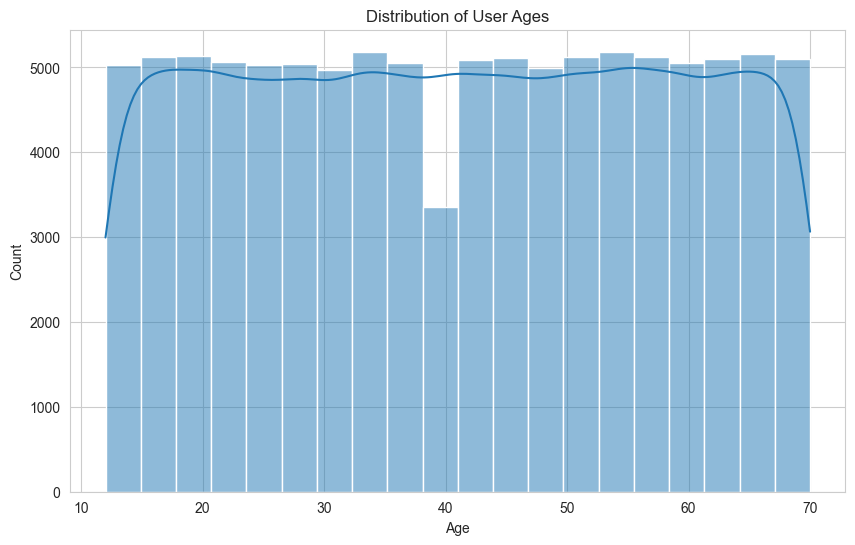

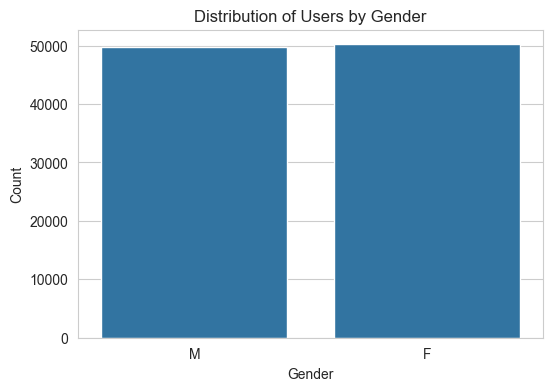

In [38]:
# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(users['age'], bins=20, kde=True)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=users, x='gender')
plt.title('Distribution of Users by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
#plt.savefig('distribution_of_users_by_gender.png')
plt.show()


# 6. Order Fulfillment Analysis

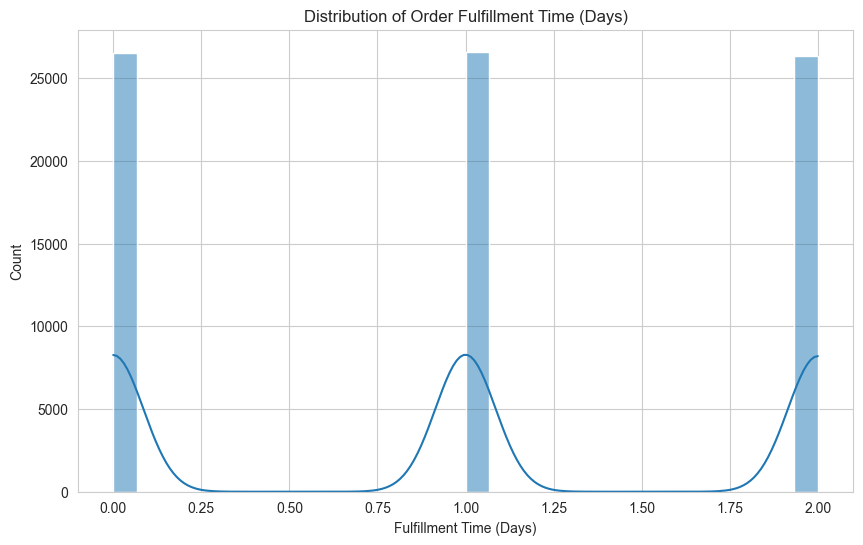

In [39]:
# Convert dates to datetime
orders['created_at'] = pd.to_datetime(orders['created_at'])
orders['shipped_at'] = pd.to_datetime(orders['shipped_at'])

# Calculate fulfillment time (from creation to shipping)
orders['fulfillment_time'] = (orders['shipped_at'] - orders['created_at']).dt.days

# Analyze fulfillment time
plt.figure(figsize=(10, 6))
sns.histplot(orders['fulfillment_time'].dropna(), bins=30, kde=True)
plt.title('Distribution of Order Fulfillment Time (Days)')
plt.xlabel('Fulfillment Time (Days)')
plt.ylabel('Count')
#plt.savefig('distribution_of_order_fulfillment_time.png')
plt.show()
